# PCA and TimesFM for Accurate RUL Prediction in NASA CMAPSS Turbofan Engines

## Introduction 

Remaining Useful Life (RUL) prediction is a critical task in predictive maintenance, particularly for complex systems like aircraft engines, where accurate forecasting can enhance safety, optimize maintenance schedules, and reduce operational costs. The NASA CMAPSS dataset, a widely used benchmark in prognostics, provides simulated turbofan engine degradation data, making it an ideal testbed for developing and evaluating RUL prediction models. This document outlines a novel approach for RUL prediction using a combination of Principal Component Analysis (PCA) and the TimesFM foundation model for time series forecasting, followed by a regression model to estimate RUL. The methodology leverages PCA to reduce the dimensionality of sensor and operational data, TimesFM to forecast future principal components, and a regression model to map these components to RUL values. The proposed workflow is evaluated on the CMAPSS FD001 dataset, with performance metrics including RMSE, R², and the NASA RUL score. The following sections detail the data processing, model architecture, implementation, and evaluation results, providing a comprehensive framework for accurate and efficient RUL prediction.

## Overall Strategy: PCA + TimesFM for Feature Forecasting + Regression for RUL

1. **Data Loading & RUL Calculation**

    * Data Loading: 
    
        Reads the train_FD001.txt, test_FD001.txt, and RUL_FD001.txt files. Make sure these files are in a CMAPSSData folder relative to your script, or adjust paths.
    
    * RUL Calculation:
    
        For the training data, it calculates the RUL for each cycle by subtracting the current time_in_cycles from the max_time_in_cycles for that specific engine.
    
    The RUL_THRESHOLD (e.g., 125) is applied to make the RUL piecewise linear. This is a common practice in CMAPSS literature: for very healthy early cycles, RUL is capped at a maximum value, as the model doesn't need to predict arbitrarily high RUL values, and the degradation signal is often not strong. This stabilizes training.


3. **Feature Selection**
   Select relevant sensor measurements and operational settings.

4. **Data Preprocessing (Scaling & PCA)**

   * Scale selected features using `MinMaxScaler`.
   * Apply **PCA** to reduce the dimensionality of the scaled features into a smaller set of **Principal Components (PCs)**.
   * The PCA model should be **fitted only on the training data**.

5. **TimesFM Forecasting of PCs**

   * For each engine's time series, get the historical sequence of PCs.
   * Use the **TimesFM** foundation model to forecast the future values of these PCs for a defined `horizon_len`.
   * TimesFM operates on **individual time series**, so you'll forecast each PC series separately.
   * ⚠️ **Important**: TimesFM is designed for general time series forecasting, not specifically for RUL. It will only predict future values of your PCs.

6. **Regression Model (PCs → RUL)**

   * Train a separate regression model (e.g., `RandomForestRegressor`) to map **current PC values** to **current RUL values**.
   * Use `(current_PCs, current_RUL)` pairs from the training data to learn this mapping.

7. **Prediction & Evaluation on Test Data**
   For each test engine:

   * Take its historical sequence of PCs.
   * Use **TimesFM** to forecast its PCs for the desired `horizon_len`.
   * Extract the **last forecasted PC vector** (or an aggregate, depending on how you define the prediction point).
   * Feed this vector into the trained **regression model** to predict the RUL.
   * Evaluate the predicted RUL against the **true RUL** using metrics like `RMSE`, `R²`, or **NASA score**.


 

## Workflow diagram 



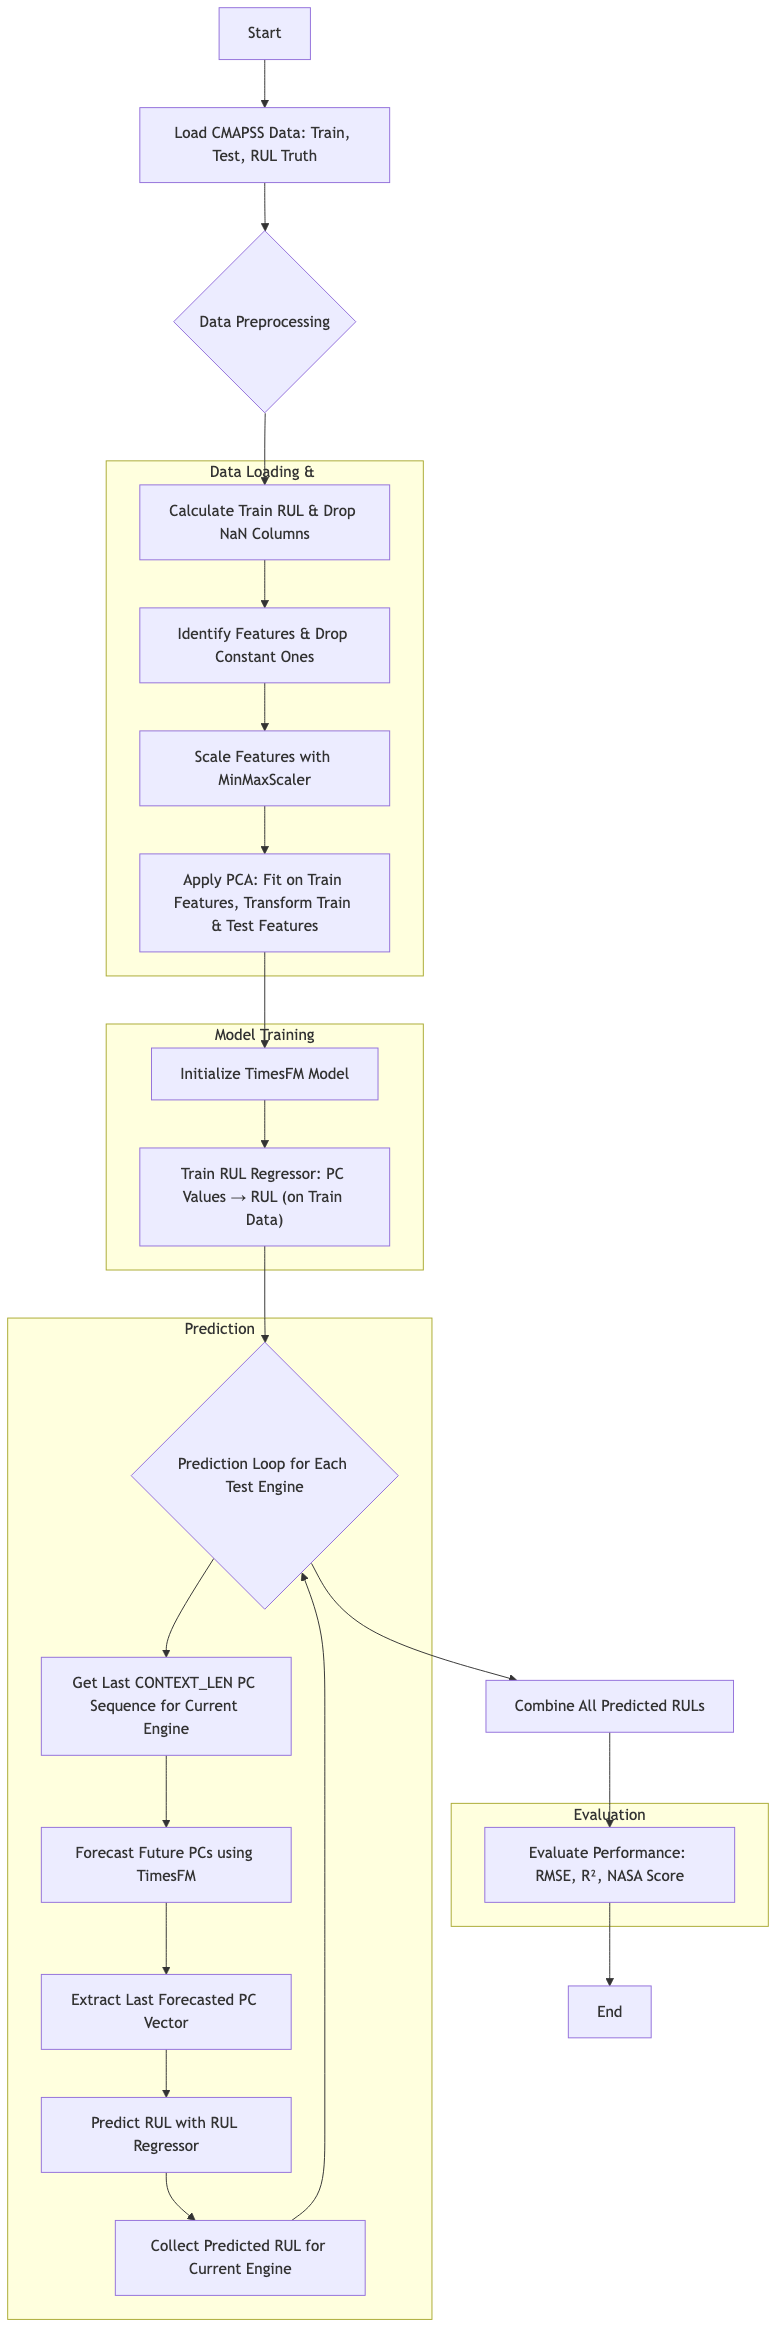

## Architecture diagram 


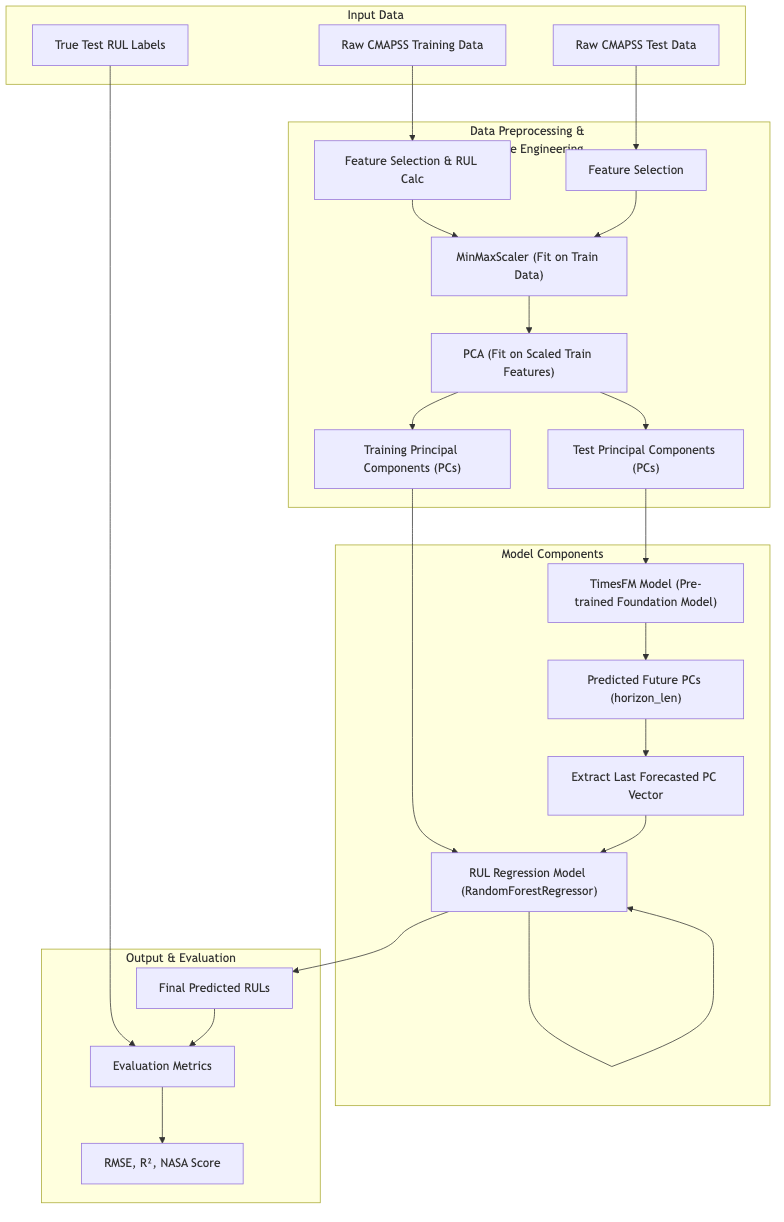

## Code Implementation 

In [274]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor # Example regression model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os 
# Import TimesFM
import timesfm
from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
import torch # TimesFM uses PyTorch backend

# --- 0. Configuration ---
# Ensure you have the CMAPSS data in a 'CMAPSSData' folder relative to your script.
# Download from NASA PCoE: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan
# Recommended: download 'CMAPSSData.zip', extract it.

# Define TimesFM parameters
CONTEXT_LEN = 64 # Max context length for TimesFM 1.0 (200M model)
HORIZON_LEN = 16  # How many future PCs to forecast for each series
FREQ = 1          # Frequency for CMAPSS cycles (1 unit per cycle)

# PCA parameters
N_COMPONENTS = 10  # Number of principal components to retain. Adjust based on explained variance.

# RUL calculation threshold (for training data)
RUL_THRESHOLD = 130

DATA_PATH =  r'/Users/pankajti/dev/data/kaggle/nasa/CMaps'


In [275]:
# --- 1. Data Loading & RUL Calculation ---

# Define column names
columns = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load FD001 data
try:
    train_path = os.path.join(DATA_PATH, 'train_FD001.txt')
    test_path = os.path.join(DATA_PATH, 'test_FD001.txt')
    rul_path = os.path.join(DATA_PATH, 'RUL_FD001.txt')

    train_df = pd.read_csv(train_path, sep=' ', header=None, names=columns, index_col=False)
    test_df = pd.read_csv(test_path, sep=' ', header=None, names=columns, index_col=False)
    rul_test_df = pd.read_csv(rul_path, sep=' ', header=None, names=['RUL'], index_col=False)
except FileNotFoundError:
    print("CMAPSS data not found. Please ensure 'CMAPSSData' folder is in the same directory as this script.")
    print("Download from: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan")
    exit() # Exit if files are not found


/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_97029/957782722.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv(train_path, sep=' ', header=None, names=columns, index_col=False)
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_97029/957782722.py:14: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  test_df = pd.read_csv(test_path, sep=' ', header=None, names=columns, index_col=False)


In [276]:
train_df.shape

(20631, 26)

In [277]:
# Drop last two columns (NaNs from dataset format)
train_df.drop(columns=['sensor_20', 'sensor_21'], inplace=True)
test_df.drop(columns=['sensor_20', 'sensor_21'], inplace=True)

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("RUL Test Data Shape:", rul_test_df.shape)

# Calculate RUL for training data
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.rename(columns={'time_in_cycles': 'max_time_in_cycles'}, inplace=True)
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']
train_df.drop(columns=['max_time_in_cycles'], inplace=True)
train_df['RUL'] = train_df['RUL'].apply(lambda x: min(x, RUL_THRESHOLD))

print("\nTrain data with RUL calculated (first 5 rows):")
#print(train_df.head())


Train Data Shape: (20631, 24)
Test Data Shape: (13096, 24)
RUL Test Data Shape: (100, 1)

Train data with RUL calculated (first 5 rows):


In [278]:
#features_to_use

In [279]:
# --- 2. Feature Selection ---

# Select sensor and operational setting features
features_to_use = [col for col in columns[:-2] if col not in ['unit_number', 'time_in_cycles']]

# Remove features with zero variance in the training data
constant_features = train_df[features_to_use].std()[train_df[features_to_use].std() == 0].index.tolist()
if constant_features:
    print(f"\nDropping constant features (zero variance): {constant_features}")
    features_to_use = [f for f in features_to_use if f not in constant_features]
else:
    print("\nNo constant features found to drop.")

print(f"Features selected for scaling and PCA: {len(features_to_use)} features.")
print(features_to_use)




Dropping constant features (zero variance): ['op_setting_3', 'sensor_1', 'sensor_10', 'sensor_18', 'sensor_19']
Features selected for scaling and PCA: 17 features.
['op_setting_1', 'op_setting_2', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17']


In [280]:
# --- 3. Data Preprocessing (Scaling & PCA) ---

# Initialize scaler (fit on training data only)
scaler = MinMaxScaler()
train_df[features_to_use] = scaler.fit_transform(train_df[features_to_use])
test_df[features_to_use] = scaler.transform(test_df[features_to_use])

# Apply PCA
pca = PCA(n_components=N_COMPONENTS)

# Create a list of PCs for each engine in training data
train_pcs_list = []
train_rul_list = [] # Corresponding RUL for each PC vector
for unit_no in train_df['unit_number'].unique():
    unit_features = train_df[train_df['unit_number'] == unit_no][features_to_use].values
    unit_rul = train_df[train_df['unit_number'] == unit_no]['RUL'].values

    # Fit PCA on the *entire* training data (all engines features concatenated)
    # This is important: PCA should capture variance across the entire fleet
    if unit_no == train_df['unit_number'].unique()[0]: # Fit PCA only once on the first unit's data (will be transformed for all)
        # However, PCA should technically be fitted on the *entire* training feature set
        # Re-fitting here would be wrong. It should be done outside the loop.
        pass

# Fit PCA on ALL training features (concatenated from all units)
pca.fit(train_df[features_to_use])
print(f"\nPCA explained variance ratio (first {N_COMPONENTS} components):")
print(pca.explained_variance_ratio_[:N_COMPONENTS])
print(f"Total explained variance by {N_COMPONENTS} components: {np.sum(pca.explained_variance_ratio_[:N_COMPONENTS]):.2f}")

# Transform both train and test features into PCs
train_pcs = pca.transform(train_df[features_to_use])
test_pcs = pca.transform(test_df[features_to_use])

# Add PCs back to dataframes (for easier grouping)
train_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]] = train_pcs
test_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]] = test_pcs

print("\nTransformed data with PCA components:")
print(train_df.head())


PCA explained variance ratio (first 10 components):
[0.48408555 0.19334026 0.06964532 0.05994084 0.05124089 0.02594298
 0.02325205 0.01962468 0.01781085 0.01421799]
Total explained variance by 10 components: 0.96

Transformed data with PCA components:
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1      0.459770      0.166667         100.0   
1            1               2      0.609195      0.250000         100.0   
2            1               3      0.252874      0.750000         100.0   
3            1               4      0.540230      0.500000         100.0   
4            1               5      0.390805      0.333333         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...      PC_1      PC_2  \
0    518.67  0.183735  0.406802  0.309757       0.0  ... -0.333538 -0.329728   
1    518.67  0.283133  0.453019  0.352633       0.0  ... -0.261776 -0.245703   
2    518.67  0.343373  0.369523  0.370527       0.

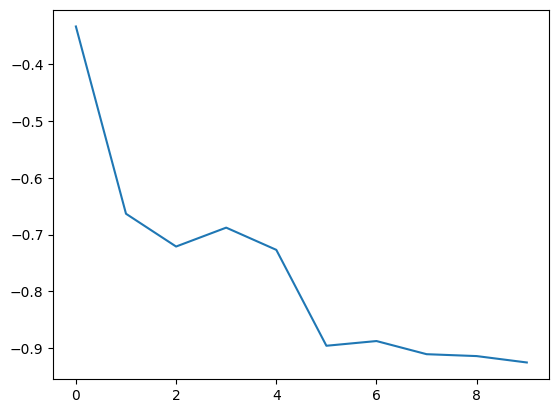

In [281]:
plt.plot(range(len(train_pcs[0])),train_pcs[0].cumsum())

In [282]:
X_reg_train.shape

(53759, 10)

In [283]:
# --- 4. TimesFM Forecasting of PCs ---

# Load TimesFM model (using CPU as GPU setup for TimesFM might be complex)
# You might need to specify the model path if not using default download.
# Ensure 'timesfm' is installed (pip install timesfm).


try:
    hparams = TimesFmHparams(
            backend="torch",
            context_len=CONTEXT_LEN,
            horizon_len=HORIZON_LEN,
            input_patch_len=32,
            output_patch_len=128,
            num_layers=20,
            model_dims=1280,
        )
    checkpoint = TimesFmCheckpoint(huggingface_repo_id="google/timesfm-1.0-200m-pytorch")
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

except Exception as e:
    print(f"\nError loading TimesFM: {e}")
    print("Please ensure 'timesfm' is installed and checkpoint files are accessible.")
    print("You might need to manually download 'timesfm-1.0-200m-cpu.ckpt' if it doesn't auto-download.")
    exit()

# Prepare training data for regression model (PC -> RUL mapping)
# We use the *current* PCs to predict the *current* RUL for training this part
X_reg_train = train_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].values
y_reg_train = train_df['RUL'].values

# --- 5. Regression Model Training (PCs to RUL) ---

# Using RandomForestRegressor as an example.  
rul_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rul_regressor.fit(X_reg_train, y_reg_train)

print("\nRegression model (PCs to RUL) trained.")



Fetching 3 files: 100%|████████████████████████| 3/3 [00:00<00:00, 65196.44it/s]



Regression model (PCs to RUL) trained.


In [284]:
forecast_pcs.shape

(10, 16)

In [285]:
#rul_regressor.predict(forecast_pcs.T)[0]

In [286]:
forecast_pcs.shape

(10, 16)

In [287]:
CONTEXT_LEN

64

## Results and Visualization

In [289]:
# --- 6. Prediction & Evaluation on Test Data ---
from tqdm import tqdm
predicted_ruls = []

# Iterate through each test engine
for unit_no in tqdm(test_df['unit_number'].unique()):
    unit_df = test_df[test_df['unit_number'] == unit_no].copy()
    
    # Get the last CONTEXT_LEN PCs for this unit
    # Ensure there are enough cycles to form the context window
    if len(unit_df) < CONTEXT_LEN:
        # Pad if the unit has fewer cycles than context_len
        # Simple padding: repeat the first available PC vector
        padding_needed = CONTEXT_LEN - len(unit_df)
        last_n_pcs = np.vstack([unit_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].iloc[0].values[np.newaxis,:] * np.ones((padding_needed, N_COMPONENTS)),
                                unit_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].values])[-CONTEXT_LEN:]
    else:
        last_n_pcs = unit_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].iloc[-CONTEXT_LEN:].values

    # TimesFM expects input shape (batch_size, num_channels, context_len)
    # Our `last_n_pcs` is (context_len, num_channels)
    # Need to reshape to (1, num_channels, context_len)
    timesfm_input = torch.tensor(last_n_pcs, dtype=torch.float32).T.unsqueeze(0) # Transpose and add batch dim

    # Forecast future PCs using TimesFM
    # The output is (batch_size, num_channels, horizon_len)
    forecast_pcs_torch, _ = tfm.forecast(timesfm_input.squeeze(), freq=[FREQ]*N_COMPONENTS)
    forecast_pcs = forecast_pcs_torch # Convert back to (horizon_len, num_channels)

    # For RUL prediction, we typically care about the RUL at the end of the
    # predicted horizon. Let's take the *last* forecasted PC vector.
    # Alternatively, you could average, or feed a sequence to an LSTM, etc.
    # For this basic implementation, we take the last forecasted PC vector.
    last_forecasted_pc_vector = forecast_pcs[-1, :].reshape(1, -1)

    # Predict RUL using the trained regression model
    predicted_rul = rul_regressor.predict(forecast_pcs.T)[0]
    predicted_ruls.append(predicted_rul)



100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.59it/s]



--- Model Evaluation (TimesFM + PCA) ---
RMSE: 19.21
R2 Score: 0.79
NASA RUL Score: 1147.42


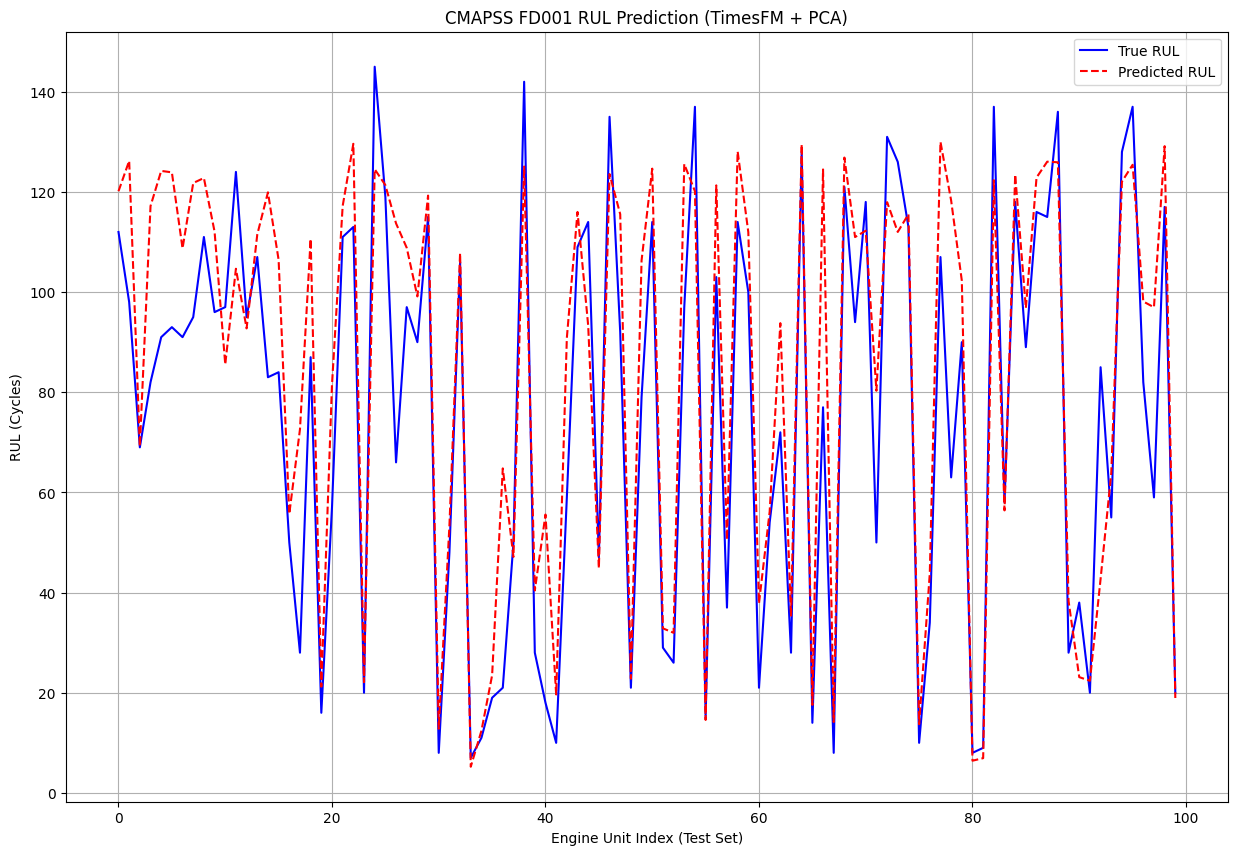

In [290]:
# Ensure predictions are non-negative
y_pred_final = np.maximum(0, np.array(predicted_ruls)).flatten()

# Get true RUL for comparison
y_true_final = rul_test_df['RUL'].values

# --- Evaluation ---

rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
r2 = r2_score(y_true_final, y_pred_final)

# NASA RUL Scoring Function
def nasa_rul_score(y_true, y_pred):
    d = y_pred - y_true
    score = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return score

nasa_score = nasa_rul_score(y_true_final, y_pred_final)

print(f"\n--- Model Evaluation (TimesFM + PCA) ---")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"NASA RUL Score: {nasa_score:.2f}")

# Plotting Results
plt.figure(figsize=(15, 10))
plt.plot(y_true_final, label='True RUL', color='blue')
plt.plot(y_pred_final, label='Predicted RUL', color='red', linestyle='--')
plt.title('CMAPSS FD001 RUL Prediction (TimesFM + PCA)')
plt.xlabel('Engine Unit Index (Test Set)')
plt.ylabel('RUL (Cycles)')
plt.legend()
plt.grid(True)
plt.show()